# CS 429: Information Retrieval

<br>

## Lecture 6: Index Compression

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology 


---


Last time:

- How do we build an index that does not fit into memory? 

Today: 

- How do we compress the contents of an index?


# Why compress an inverted index?


- Save disk space
- Fit as much in memory as possible (caching)
- Faster transfer from disk to memory

# What will we compress?

- Vocabulary
- Postings lists

<br>

To help compression, we need to know

- How large should we expect the vocabulary to be?
  - helpful to compress vocabulary
- How are terms distributed throughout documents?
  - helpful to compress postings lists

# Will the vocabulary get *that* big?

- $T$ = number of tokens
- $V$ = number of terms

Can we estimate $V$ as a function of $T$?

$V = f(T)$

In [80]:
# Let's read in some documents.
# This is a dataset of 11K newsgroups posts: http://qwone.com/~jason/20Newsgroups/
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes')).data
print('read %d docs' % len(docs))

read 11314 docs


In [81]:
# Let's look at a couple documents.
docs[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [82]:
docs[10]

'I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs\nvery well, paint is the bronze/brown/orange faded out, leaks a bit of oil\nand pops out of 1st with hard accel.  The shop will fix trans and oil \nleak.  They sold the bike to the 1 and only owner.  They want $3495, and\nI am thinking more like $3K.  Any opinions out there?  Please email me.\nThanks.  It would be a nice stable mate to the Beemer.  Then I\'ll get\na jap bike and call myself Axis Motors!\n\n-- \n-----------------------------------------------------------------------\n"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx\nirwin@cmptrc.lonestar.org    DoD #0826          (R75/6)'

### Next, let's count the number of terms and tokens in this dataset.

In [83]:
from collections import defaultdict
import re

# Count the number of terms and tokens in a list of documents.
# return
#  1. terms: a dict from term to number of documents it appears in
#  2. n_tokens: the number of tokens in docs
def count_terms_and_toks(docs):
    terms = defaultdict(lambda: 0)  # Map from term to count.
    n_tokens = 0
    for d in docs:
        d_terms = set()  # increment each term once per document.
        for tok in re.findall('[\w]+',d.lower()):
            d_terms.add(tok)
            n_tokens += 1
        for d_term in d_terms:
            terms[d_term] += 1

    return terms, n_tokens

In [84]:
terms, n_tokens = count_terms_and_toks(docs)
print('found %d tokens and %d terms' % (n_tokens, len(terms)))

found 2407167 tokens and 101675 terms


How does the number of terms vary with the number of tokens?

In [85]:
# Compute T/V for different subsets of the documents.
T = []
V = []
for n_docs in [10, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000]:
    terms, n_tokens = count_terms_and_toks(docs[:n_docs])
    print('found %d tokens and %d terms in %d docs' % (n_tokens, len(terms), n_docs))
    T.append(n_tokens)
    V.append(len(terms))

found 1270 tokens and 545 terms in 10 docs
found 20449 tokens and 4941 terms in 100 docs
found 50302 tokens and 8847 terms in 200 docs
found 105451 tokens and 17724 terms in 500 docs
found 209463 tokens and 24469 terms in 1000 docs
found 435261 tokens and 39715 terms in 2000 docs
found 619559 tokens and 46007 terms in 3000 docs
found 858039 tokens and 54858 terms in 4000 docs
found 1123563 tokens and 63360 terms in 5000 docs
found 2155073 tokens and 92703 terms in 10000 docs


Populating the interactive namespace from numpy and matplotlib


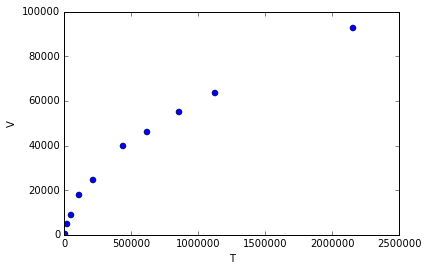

In [86]:
# Let's plot the results.
% pylab inline
xlabel('T')
ylabel('V')
plot(T, V, 'bo')

Is this linear, polynomial, something else?

linear fit=0.04*x + 11948.88


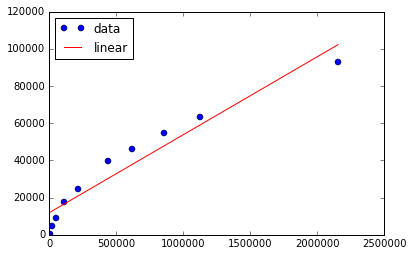

In [87]:
# Let's try a linear fit
import numpy as np
linear = np.polyfit(T, V, 1)  # fit slope and intercept
print('linear fit=%.2f*x + %.2f' % (linear[0], linear[1]))
plot(T, V, 'bo', label='data')  # bo = blue circle
plot(T, np.polyval(linear, T), 'r-', label='linear')  # r- = red solid line
legend(loc='best')

# Heaps' Law

An observed relation between $V$ and $T$:

$V = k T^b$

for constants $k$ (typically $30 < k < 100$) and $b$ (typically $b \approx 0.5$)

In [11]:
# How do we set k and b in Heaps' Law?
# Minimize mean squared error.
from scipy.optimize import curve_fit
help(curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, **kw)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : An M-length sequence or an (k,M)-shaped array
        for functions with k predictors.
        The independent variable where the data is measured.
    ydata : M-length sequence
        The dependent data --- nominally f(xdata, ...)
    p0 : None, scalar, or N-length sequence, optional
        Initial guess for the parameters.  If None, then the initial
        values will all be 1 (if the number of parameters for the function
        can be determined using introspection, otherwise

In [88]:
# V = k * T^b
def heaps(T, k, b):
    return k*(T**b)

In [89]:
# Fit k and b
heap_parms,covar = curve_fit(heaps, T, V)
print('Heaps fit is %.2f*T^%.2f' % (heap_parms[0], heap_parms[1]))

Heaps fit is 23.48*T^0.57


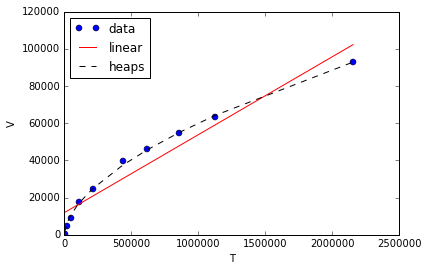

In [90]:
# Compare linear fit and Heaps fit
plot(T, V, 'bo', label='data')
plot(T, np.polyval(linear, T), 'r-', label='linear')
plot(T, heaps(T, *heap_parms), 'k--', label='heaps')  # k-- = black dashed line
xlabel('T')
ylabel('V')
legend(loc='best')

In [91]:
print('Heaps predicts %d terms for %d tokens, truth is %d.' % (heaps(T[-1], *heap_parms), T[-1], V[-1]))

Heaps predicts 92848 terms for 2155073 tokens, truth is 92703.


# How are terms distributed across documents?

- How many times does the most frequent term occur? The $i$th most frequent term?

In [92]:
# Let's plot and see.
# Recall that terms is a dict from term to document frequency
print('"the" occurs in %d documents; "honda" occurs in %d documents' % (terms['the'], terms['honda']))

"the" occurs in 8373 documents; "honda" occurs in 61 documents


In [93]:
# Sort frequency values in descending order
freqs = sorted(terms.values(), reverse=True)
print('top 10 frequencies are', freqs[:10])

top 10 frequencies are [8373, 7479, 7396, 6912, 6870, 6781, 6287, 6206, 5884, 5814]


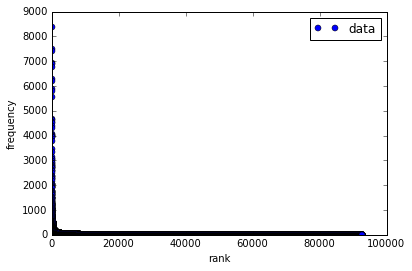

In [94]:
ranks = range(1, len(freqs)+1)
plot(ranks, freqs, 'bo', label='data')
legend(loc='best')
xlabel('rank')
ylabel('frequency')

In [95]:
print('%d/%d terms occur in only one document.' % (len([x for x in freqs if x == 1]), len(freqs)))

56273/92703 terms occur in only one document.


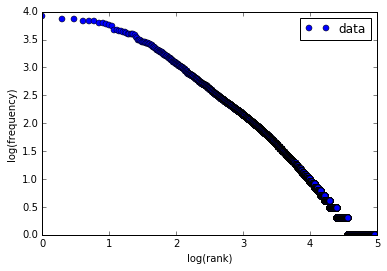

In [96]:
# That was ugly. The values decrease too rapidly. Let's try a log-log plot.
l_ranks = np.log10(ranks)
l_freqs = np.log10(freqs)
plot(l_ranks, l_freqs, 'bo', label='data')
legend(loc='best')
xlabel('log(rank)')
ylabel('log(frequency)')

# Zipf's Law

Another empirical law that states that the frequency of a term is inversely proportional to its rank.

Let $f_i$ be the frequency of the $i$th most common term.

$ f_i \propto \frac{1}{i} $ 

equivalently

$ f_i = k$ $i^b $ for constant $k$ and $b=-1$

(c.f. Heap's law: $V = kT^b$)

In [98]:
# Define the Zipf function and fit the k parameter.
def zipfs(i, k):
    return k / i
zipf_parms,covar = curve_fit(zipfs, ranks, freqs)
print('Zipf fit is %.2f*T^-1' % zipf_parms[0])

Zipf fit is 18138.31*T^-1


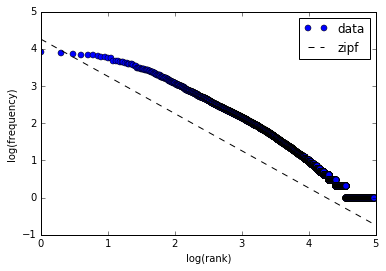

In [99]:
plot(l_ranks, l_freqs, 'bo', label='data')
xlabel('log(rank)')
ylabel('log(frequency)')
plot(l_ranks, log10(zipfs(ranks, *zipf_parms)), 'k--', label='zipf')  # k-- = black dashed line
legend(loc='best')

In [100]:
# What is the predicted frequency of the term at rank 92688?
slope = zipf_parms[0]
print(slope / 92688)

0.195692068798


In [101]:
def pred_num_terms(frequency, terms, slope):
    return len([x for x in range(1,len(terms)) if slope / x <= frequency and slope / x > frequency-1])

In [102]:
# How many terms occur once according to Zipf??
print(pred_num_terms(1, terms, slope))

74564


In [103]:
# How many terms occur twice according to Zipf??
print(pred_num_terms(2, terms, slope))

9069


In [104]:
# How many terms occur once in data?
def obs_num_terms(frequency, terms):
    return len([t for t in terms if terms[t] == frequency])

In [105]:
# How many terms occur once in data?
obs_num_terms(1, terms)

56273

In [106]:
# How many terms occur twice in data?
obs_num_terms(2, terms)

11264

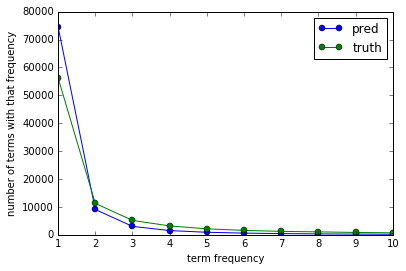

In [107]:
pred = [pred_num_terms(x, terms, slope) for x in range(1, 11)]
truth = [obs_num_terms(x, terms) for x in range(1, 11)]
plot(range(1, 11), pred, 'bo-', label='pred')
plot(range(1, 11), truth, 'go-', label='truth')
legend(loc='best')
xlabel('term frequency')
ylabel('number of terms with that frequency')

# Dictionary compression

Why compress the dictionary?

# Dictionary compression


$ \begin{eqnarray*}
\mathbf{dog} & \rightarrow & [1, 6, 20] \\
\mathbf{cat} & \rightarrow & [7, 16, 32] \\
\end{eqnarray*}
$

1. Fixed-width storage
2. One big string
3. Blocked storage
4. Front encoding

# Fixed-width storage

![fixed](files/fixed.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)

Space = $(20 + 4 + 4)V  = 28V$ bytes

Why is 20 bytes / term wasteful?

Average term $\approx$ 8 bytes

# One big string

![string](files/string.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)

Assuming average term is 8 bytes, 

Space = $(8 + 4 + 4 + 3)V = 19V$ bytes (reduction from $28V$)

# Blocked storage

Reduce number of term pointers:

![block](files/block.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)

- Assume $k$ blocks, we store only $k$ term pointers (instead of $V$)
- But, we also need to add one byte per term for offsets (term length)

Space = $(8 + 4 + 4)V + k + V = 17V + k$ bytes (reduction from $19V$)

Why not use $k=1$?

# Front encoding

![front](files/front.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)

Savings depends on chosen prefixes.

# Dictionary compression results

![sizes](files/sizes.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)

Note that 28V / 19V $\approx$ 11.2 / 7.6

# Compression postings lists

$ \begin{eqnarray*}
dog & \rightarrow & \mathbf{[1, 6, 20]} \\
cat & \rightarrow & \mathbf{[7, 16, 32]} \\
\end{eqnarray*}
$

How many bits to represent a doc ID?

$log_2(D)$ for $D$ documents in dataset.

So, postings list for a term that appears in $n$ documents requires $n log_2(D)$ bits.

# Storing gaps

**Idea:** Store only gaps between doc IDs. Hope that the range of gaps is less than the number of documents. E.g.

$ dog \rightarrow [101, 102, 104, 107] $

becomes

$ dog \rightarrow [101, 1, 2, 3] $


Instead of $log_2(D)$, each ID is stored in $log_2(M)$, where $M$ is maximum gap.

What about rare words?

$ defenestrate \rightarrow [100, 99999100] $

becomes

$ defenestrate \rightarrow [100, 99999000] $


# Variable byte encoding

**Idea:** Use more bytes for larger numbers. 

E.g., 

- doc ID $4 \rightarrow 100$ (3 bits)
- doc ID $4000 \rightarrow 111110100000$ (12 bits)

What's the problem with this?

4 followed by 400 becomes: $100111110100000$ 

Where does one ID end and the next begin?

**Idea:**

- For each byte, let the final 7 bits be a subsequence of an ID;
- Let the first bit be 1 if this is the final byte for this ID

$4 \rightarrow $ <font color='blue'><u>**1**</u>0000100</font> (<font color='blue'><u>1</u></font> = final byte, <font color='blue'>0000100</font> = ID 4)

$4000 \rightarrow$ <font color='blue'><u>**0**</u>0011111</font><font color="orange"><u>**1**</u>0100000</font> $\rightarrow$ <font color='blue'><u>**_**</u>0011111</font><font color="orange"><u>**_**</u>0100000</font> $\rightarrow$ 00111110100000



![vb](files/vb.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)


![sizes2](files/sizes2.png)

[MRS](http://nlp.stanford.edu/IR-book/pdf/05comp.pdf)


# How many bytes to store $n$ postings lists?

Need to know how many doc ids in each postings list.

Recall Zipf:

$ f_i = \frac{k}{i} $ for constant $k$

so, most frequent term has $k$ doc ids, next most frequent has $\frac{k}{2}$, next has $\frac{k}{3}$, etc.

Have to make some assumption about gap sizes: e.g., uniform $ [100, 200, 300, 400, ...] $

$\begin{eqnarray*}
term_1 & = & [\frac{D}{k}, 2\frac{D}{k}, 3\frac{D}{k}, \ldots, k\frac{D}{k}]\\
term_2 & = & [\frac{2D}{k}, 2\frac{2D}{k}, 3\frac{2D}{k}, \ldots, k\frac{2D}{k}]\\
\vdots\\
term_i & = & [\frac{iD}{k}, 2\frac{iD}{k}, 3\frac{iD}{k}, \ldots, k\frac{iD}{k}]\\
\end{eqnarray*}
$


In terms of $D$, $k$, what is

- average gap size?
- total number of gaps?